# Batting Basic Modeling

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import r2_score, mean_squared_error

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
AdaBoostClassifier, GradientBoostingClassifier

from pickle import dump, load

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)

np.random_state = 42

In [2]:
# load batting_basic
batting_basic = pd.read_csv('Data/batting_basic', index_col = 0)
batting_basic = batting_basic.drop(columns = ['Season', 'Name'])
batting_basic

,POS,Team,Age,Salary,Adjusted 2021 Salary,G,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,OBP,SLG,OPS
0,OF,CHW,27.0,255000.0,394926.0,80.0,215.0,242.0,0.274,59.0,40.0,15.0,1.0,3.0,31.0,29.0,21.0,1.0,38.0,2.0,1.0,2.0,2.0,2.0,1.0,0.343,0.395,0.738
1,2B,NYM,31.0,500000.0,774365.0,79.0,157.0,173.0,0.217,34.0,20.0,7.0,1.0,6.0,22.0,12.0,14.0,2.0,51.0,1.0,1.0,0.0,2.0,1.0,1.0,0.283,0.389,0.672
2,OF,MIA,24.0,327000.0,430203.0,111.0,255.0,281.0,0.212,54.0,35.0,12.0,2.0,5.0,39.0,24.0,18.0,2.0,78.0,3.0,1.0,4.0,2.0,6.0,5.0,0.271,0.333,0.604
3,2B,TBR,23.0,215000.0,321031.0,79.0,304.0,335.0,0.270,82.0,59.0,17.0,1.0,5.0,43.0,33.0,27.0,1.0,35.0,0.0,1.0,3.0,3.0,8.0,3.0,0.328,0.382,0.710
4,2B,TBR,24.0,215000.0,317237.0,117.0,463.0,504.0,0.242,112.0,88.0,18.0,4.0,2.0,46.0,40.0,25.0,0.0,46.0,6.0,2.0,8.0,8.0,10.0,4.0,0.288,0.311,0.599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9136,C,SEA,25.0,523500.0,577574.0,55.0,164.0,192.0,0.207,34.0,15.0,7.0,0.0,12.0,16.0,31.0,21.0,0.0,65.0,6.0,1.0,0.0,0.0,0.0,0.0,0.318,0.470,0.787
9137,C,SEA,26.0,570000.0,613477.0,124.0,387.0,435.0,0.251,97.0,47.0,25.0,0.0,25.0,52.0,64.0,39.0,0.0,160.0,8.0,1.0,0.0,8.0,1.0,0.0,0.331,0.509,0.840
9138,C,SEA,27.0,2975000.0,3135948.0,113.0,373.0,405.0,0.201,75.0,37.0,18.0,0.0,20.0,37.0,44.0,24.0,0.0,150.0,6.0,2.0,0.0,7.0,0.0,0.0,0.259,0.410,0.669
9139,C,TBR,28.0,4412000.0,4582035.0,90.0,266.0,289.0,0.165,44.0,24.0,10.0,1.0,9.0,30.0,32.0,20.0,0.0,98.0,3.0,0.0,0.0,4.0,0.0,0.0,0.232,0.312,0.544


## Checking Correlations Between Features

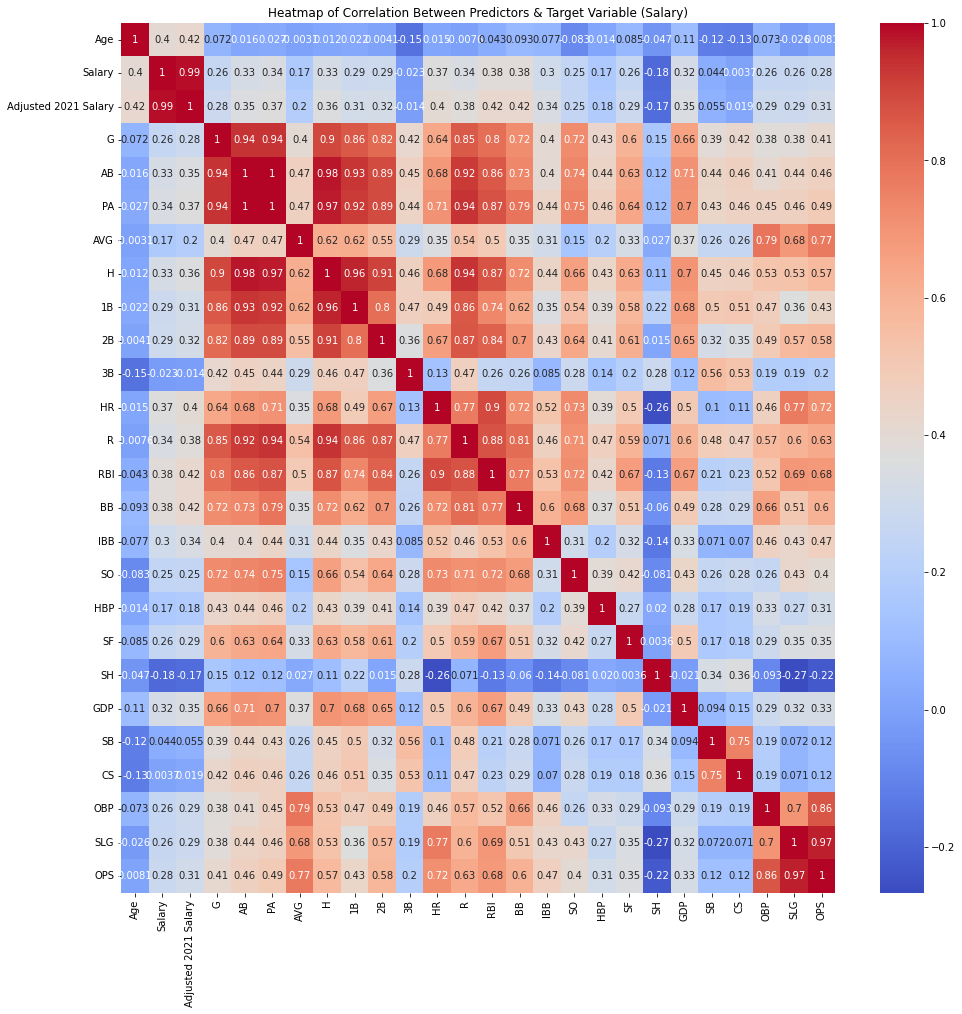

In [3]:
# set up figure size
fig, ax = plt.subplots(figsize=(16, 16))

# set up correlation matrix
corr = batting_basic.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Predictors & Target Variable (Salary)");

plt.show()

We see that from this correlation map, that many of the basic hitting stats are highly correlated with each other (highlighted by the red in the upper left). 

Additionally, we see that some of the stats such as OBP, SLG, and OPS are also highly correlated with each other as expected (OPS is the sum of OBP and SLG). 

## Feature Selection

**Multicollinearity**

In [4]:
corr_df = batting_basic.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))

# set index to pairs
corr_df.set_index(['pairs'], inplace = True)

#drop level columns
corr_df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
corr_df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
corr_df.drop_duplicates(inplace=True)

In [5]:
corr_df[(corr_df.cc>0.9) & (corr_df.cc <1)]

,cc
pairs,
"(PA, AB)",0.996289
"(Adjusted 2021 Salary, Salary)",0.989216
"(H, AB)",0.975933
"(PA, H)",0.972981
"(SLG, OPS)",0.965499
"(H, 1B)",0.963901
"(R, H)",0.937834
"(PA, G)",0.937456
"(PA, R)",0.936708


Lots of collinear features. We will selectively remove the top offenders where the features are most collinearly related with each other.

**Feature Selection Using `feature_selection`**

In [6]:
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel, mutual_info_regression

In [7]:
feature_selector = SelectKBest(mutual_info_regression, k = 10)

In [8]:
df = batting_basic[['Age', 'G', 'AVG', 'H', '1B', '2B',
       '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SH', 'GDP',
       'SB', 'CS', 'OBP', 'SLG', 'OPS']]

In [9]:
feature_selector.fit(df, batting_basic['Adjusted 2021 Salary'])

# get top features
df.columns[feature_selector.get_support()]

Index(['Age', 'H', '1B', '2B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'GDP'], dtype='object')

### Grouping by Name and Averages
During the modeling process, we observed that while we have more rows of data for the `batting_basic` table, it is extremely difficult for the model to determine a projected player's salary since we are considering many different rows for the same player for multiple years. 

Lets simplify the model even further by grouping `batting_basic` by player names and determining the average of every other feature. 

In [10]:
bb_grouped = pd.read_csv('Data/batting_basic', index_col = 0)

In [11]:
bb_grouped

,Season,Name,POS,Team,Age,Salary,Adjusted 2021 Salary,G,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,OBP,SLG,OPS
0,2000.0,Jeff Abbott,OF,CHW,27.0,255000.0,394926.0,80.0,215.0,242.0,0.274,59.0,40.0,15.0,1.0,3.0,31.0,29.0,21.0,1.0,38.0,2.0,1.0,2.0,2.0,2.0,1.0,0.343,0.395,0.738
1,2000.0,Kurt Abbott,2B,NYM,31.0,500000.0,774365.0,79.0,157.0,173.0,0.217,34.0,20.0,7.0,1.0,6.0,22.0,12.0,14.0,2.0,51.0,1.0,1.0,0.0,2.0,1.0,1.0,0.283,0.389,0.672
2,2006.0,Reggie Abercrombie,OF,MIA,24.0,327000.0,430203.0,111.0,255.0,281.0,0.212,54.0,35.0,12.0,2.0,5.0,39.0,24.0,18.0,2.0,78.0,3.0,1.0,4.0,2.0,6.0,5.0,0.271,0.333,0.604
3,2001.0,Brent Abernathy,2B,TBR,23.0,215000.0,321031.0,79.0,304.0,335.0,0.270,82.0,59.0,17.0,1.0,5.0,43.0,33.0,27.0,1.0,35.0,0.0,1.0,3.0,3.0,8.0,3.0,0.328,0.382,0.710
4,2002.0,Brent Abernathy,2B,TBR,24.0,215000.0,317237.0,117.0,463.0,504.0,0.242,112.0,88.0,18.0,4.0,2.0,46.0,40.0,25.0,0.0,46.0,6.0,2.0,8.0,8.0,10.0,4.0,0.288,0.311,0.599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9136,2016.0,Mike Zunino,C,SEA,25.0,523500.0,577574.0,55.0,164.0,192.0,0.207,34.0,15.0,7.0,0.0,12.0,16.0,31.0,21.0,0.0,65.0,6.0,1.0,0.0,0.0,0.0,0.0,0.318,0.470,0.787
9137,2017.0,Mike Zunino,C,SEA,26.0,570000.0,613477.0,124.0,387.0,435.0,0.251,97.0,47.0,25.0,0.0,25.0,52.0,64.0,39.0,0.0,160.0,8.0,1.0,0.0,8.0,1.0,0.0,0.331,0.509,0.840
9138,2018.0,Mike Zunino,C,SEA,27.0,2975000.0,3135948.0,113.0,373.0,405.0,0.201,75.0,37.0,18.0,0.0,20.0,37.0,44.0,24.0,0.0,150.0,6.0,2.0,0.0,7.0,0.0,0.0,0.259,0.410,0.669
9139,2019.0,Mike Zunino,C,TBR,28.0,4412000.0,4582035.0,90.0,266.0,289.0,0.165,44.0,24.0,10.0,1.0,9.0,30.0,32.0,20.0,0.0,98.0,3.0,0.0,0.0,4.0,0.0,0.0,0.232,0.312,0.544


### Adding Salary Difference

A good indicator of a player's salary could be accounting for the player's difference in salary each year. This could address the large salary difference for players who make a significant amount more in their free agency year. 

In [12]:
bb_grouped['Salary Difference'] = bb_grouped['Adjusted 2021 Salary'].diff()
bb_grouped = bb_grouped.fillna(0)
bb_grouped

,Season,Name,POS,Team,Age,Salary,Adjusted 2021 Salary,G,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,OBP,SLG,OPS,Salary Difference
0,2000.0,Jeff Abbott,OF,CHW,27.0,255000.0,394926.0,80.0,215.0,242.0,0.274,59.0,40.0,15.0,1.0,3.0,31.0,29.0,21.0,1.0,38.0,2.0,1.0,2.0,2.0,2.0,1.0,0.343,0.395,0.738,0.0
1,2000.0,Kurt Abbott,2B,NYM,31.0,500000.0,774365.0,79.0,157.0,173.0,0.217,34.0,20.0,7.0,1.0,6.0,22.0,12.0,14.0,2.0,51.0,1.0,1.0,0.0,2.0,1.0,1.0,0.283,0.389,0.672,379439.0
2,2006.0,Reggie Abercrombie,OF,MIA,24.0,327000.0,430203.0,111.0,255.0,281.0,0.212,54.0,35.0,12.0,2.0,5.0,39.0,24.0,18.0,2.0,78.0,3.0,1.0,4.0,2.0,6.0,5.0,0.271,0.333,0.604,-344162.0
3,2001.0,Brent Abernathy,2B,TBR,23.0,215000.0,321031.0,79.0,304.0,335.0,0.270,82.0,59.0,17.0,1.0,5.0,43.0,33.0,27.0,1.0,35.0,0.0,1.0,3.0,3.0,8.0,3.0,0.328,0.382,0.710,-109172.0
4,2002.0,Brent Abernathy,2B,TBR,24.0,215000.0,317237.0,117.0,463.0,504.0,0.242,112.0,88.0,18.0,4.0,2.0,46.0,40.0,25.0,0.0,46.0,6.0,2.0,8.0,8.0,10.0,4.0,0.288,0.311,0.599,-3794.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9136,2016.0,Mike Zunino,C,SEA,25.0,523500.0,577574.0,55.0,164.0,192.0,0.207,34.0,15.0,7.0,0.0,12.0,16.0,31.0,21.0,0.0,65.0,6.0,1.0,0.0,0.0,0.0,0.0,0.318,0.470,0.787,-7148.0
9137,2017.0,Mike Zunino,C,SEA,26.0,570000.0,613477.0,124.0,387.0,435.0,0.251,97.0,47.0,25.0,0.0,25.0,52.0,64.0,39.0,0.0,160.0,8.0,1.0,0.0,8.0,1.0,0.0,0.331,0.509,0.840,35903.0
9138,2018.0,Mike Zunino,C,SEA,27.0,2975000.0,3135948.0,113.0,373.0,405.0,0.201,75.0,37.0,18.0,0.0,20.0,37.0,44.0,24.0,0.0,150.0,6.0,2.0,0.0,7.0,0.0,0.0,0.259,0.410,0.669,2522471.0
9139,2019.0,Mike Zunino,C,TBR,28.0,4412000.0,4582035.0,90.0,266.0,289.0,0.165,44.0,24.0,10.0,1.0,9.0,30.0,32.0,20.0,0.0,98.0,3.0,0.0,0.0,4.0,0.0,0.0,0.232,0.312,0.544,1446087.0


In [13]:
# group by Name and find averages across all other features
bb_grouped = bb_grouped.groupby(['Name']).mean()
bb_grouped = bb_grouped.drop(columns = 'Season')
bb_grouped.head()

,Age,Salary,Adjusted 2021 Salary,G,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,OBP,SLG,OPS,Salary Difference
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,
A.J. Ellis,33.0,2.125778e+06,2.359374e+06,73.333333,215.000000,254.444444,0.242667,51.666667,37.333333,9.111111,0.333333,4.888889,21.444444,25.333333,31.111111,2.444444,45.666667,3.111111,2.000000,3.222222,7.444444,0.222222,0.444444,0.344556,0.349778,0.694333,8.238856e+04
Aaron Altherr,25.5,5.326250e+05,5.788645e+05,77.000000,237.500000,271.250000,0.224000,54.500000,30.000000,13.000000,2.500000,9.000000,33.500000,37.000000,26.750000,1.000000,76.250000,5.500000,1.250000,0.250000,8.000000,5.250000,2.500000,0.319250,0.407750,0.727000,-2.268758e+06
Aaron Boone,31.0,1.696875e+06,2.330354e+06,116.125000,394.500000,442.500000,0.263500,102.750000,65.750000,22.000000,1.250000,13.750000,54.250000,56.250000,32.000000,2.125000,73.125000,8.250000,3.625000,3.750000,8.000000,10.375000,2.875000,0.331000,0.425125,0.756000,-1.350900e+04
Aaron Cunningham,25.0,4.823000e+05,5.694040e+05,59.000000,106.333333,119.000000,0.213667,23.666667,14.000000,7.333333,0.666667,1.666667,11.333333,10.333333,8.333333,0.666667,23.333333,1.333333,1.333333,1.666667,1.666667,0.666667,2.000000,0.277667,0.343667,0.621667,3.013700e+04
Aaron Guiel,30.5,3.200000e+05,4.549862e+05,61.000000,209.500000,237.000000,0.240000,51.750000,31.750000,13.000000,0.000000,7.000000,31.500000,27.500000,17.250000,0.500000,46.750000,6.250000,2.750000,1.250000,3.000000,1.500000,2.750000,0.315000,0.393250,0.708000,-3.983875e+04


In [14]:
bb_grouped.describe()

,Age,Salary,Adjusted 2021 Salary,G,AB,PA,AVG,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,OBP,SLG,OPS,Salary Difference
count,1843.000000,1.843000e+03,1.843000e+03,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1843.000000,1.843000e+03
mean,27.968150,2.204595e+06,2.663292e+06,91.934177,282.797541,316.285721,0.248031,72.716435,47.874775,14.455991,1.541317,8.844352,37.667061,35.658450,26.676196,1.733090,61.875750,3.073449,2.139115,1.546682,6.246987,4.533399,1.872941,0.315374,0.393516,0.708889,-6.301201e+05
std,3.427843,2.881333e+06,3.529113e+06,28.120463,122.096963,137.821296,0.028187,36.129424,24.008415,7.673284,1.368729,7.123622,20.072173,21.016133,16.754080,2.409017,28.238575,2.649583,1.496159,1.846425,3.775335,5.818032,1.833059,0.032778,0.063052,0.087447,3.046652e+06
min,20.000000,2.000000e+05,2.000000e+05,30.000000,88.000000,100.000000,0.121000,12.000000,8.000000,0.000000,0.000000,0.000000,5.000000,2.000000,1.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.193000,0.194000,0.395000,-2.842143e+07
25%,25.500000,4.900000e+05,5.564778e+05,70.225000,178.875000,199.416667,0.231690,42.183333,28.000000,8.083333,0.500000,3.250000,21.000000,19.000000,14.500000,0.333333,40.000000,1.000000,1.000000,0.000000,3.500000,1.000000,0.571429,0.294388,0.350523,0.652857,-4.658512e+05
50%,27.500000,8.166667e+05,9.810973e+05,93.600000,267.750000,297.833333,0.250111,67.000000,44.600000,13.166667,1.200000,7.000000,33.857143,31.250000,23.000000,1.000000,58.000000,2.400000,2.000000,1.000000,5.500000,2.500000,1.333333,0.316250,0.393500,0.709000,1.343571e+03
75%,30.000000,2.771312e+06,3.345999e+06,114.000000,378.769231,423.053571,0.266500,99.500000,64.825000,19.954545,2.166667,12.571429,51.000000,48.809091,35.236364,2.250000,79.333333,4.166667,3.000000,2.250000,8.354167,6.000000,2.654762,0.336633,0.433194,0.762500,3.071415e+05
max,44.500000,2.429698e+07,3.087142e+07,155.058824,613.928571,688.785714,0.329000,189.000000,147.352941,37.000000,8.714286,44.571429,109.142857,108.000000,159.857143,55.285714,170.000000,23.000000,10.000000,12.000000,20.700000,43.857143,14.500000,0.515571,0.717286,1.233000,1.390342e+07


## Train-Test Split

Using domain knowledge and the above `feature_selection`, we wil define the X as features we want to keep for the Train-Test Split

**Splitting the Batting Basic**

In [15]:
batting_basic.columns

Index(['POS', 'Team', 'Age', 'Salary', 'Adjusted 2021 Salary', 'G', 'AB', 'PA',
       'AVG', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO',
       'HBP', 'SF', 'SH', 'GDP', 'SB', 'CS', 'OBP', 'SLG', 'OPS'],
      dtype='object')

In [16]:
# feature selection, target variable = 'Adjusted 2021 Salary'
X = batting_basic[['Age', 'H', 'R', 'RBI', 'BB', 'SO',
               'SF', 'SH', 'GDP', 'SB', 'OPS']]

y = batting_basic['Adjusted 2021 Salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [17]:
X_train.head(3)

,Age,H,R,RBI,BB,SO,SF,SH,GDP,SB,OPS
5274,26.0,64.0,42.0,17.0,32.0,68.0,2.0,12.0,4.0,9.0,0.603
4482,32.0,36.0,21.0,16.0,22.0,44.0,0.0,0.0,8.0,2.0,0.733
3550,24.0,84.0,39.0,29.0,21.0,88.0,1.0,2.0,4.0,3.0,0.735


**Splitting the Batting Basic Grouped**

In [18]:
bb_grouped.columns

Index(['Age', 'Salary', 'Adjusted 2021 Salary', 'G', 'AB', 'PA', 'AVG', 'H',
       '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF',
       'SH', 'GDP', 'SB', 'CS', 'OBP', 'SLG', 'OPS', 'Salary Difference'],
      dtype='object')

In [74]:
top_features = ['Salary Difference', 'Age', 'H', 'R', 'RBI', 'BB', 'SO', 'SB', 'OPS']

In [75]:
# feature selection, target variable = 'Adjusted 2021 Salary'
X = bb_grouped[['Salary Difference', 'Age', 'H', 'R', 'RBI', 'BB', 'SO', 'SB', 'OPS']]
y = bb_grouped['Adjusted 2021 Salary']

grouped_X_train, grouped_X_test, grouped_y_train, grouped_y_test = train_test_split(X, y, random_state= 42)

In [105]:
grouped_X_train

,Salary Difference,Age,H,R,RBI,BB,SO,SB,OPS
Name,,,,,,,,,
Jordany Valdespin,-2.626450e+06,25.000000,30.666667,17.333333,17.333333,9.000000,29.333333,5.000000,0.634333
Nelson Cruz,8.163194e+05,31.642857,122.500000,65.428571,78.357143,42.857143,111.571429,5.642857,0.850071
Angel Berroa,2.198646e+05,27.200000,124.800000,60.600000,48.200000,20.800000,84.800000,9.000000,0.673600
Eric Hosmer,1.472727e+06,26.000000,148.090909,69.727273,75.909091,47.181818,104.181818,6.909091,0.771091
Yasmani Grandal,1.643256e+06,27.500000,77.700000,46.100000,50.500000,57.400000,91.300000,1.100000,0.799800
...,...,...,...,...,...,...,...,...,...
Lou Collier,-1.893676e+06,27.000000,32.000000,19.000000,14.000000,17.000000,30.000000,5.000000,0.718000
Mike Kinkade,-1.435950e+04,29.000000,39.500000,22.000000,15.000000,13.500000,34.500000,1.500000,0.706500
Jeremy Hermida,7.407274e+05,24.000000,97.600000,46.400000,45.600000,40.000000,94.400000,3.800000,0.731600


In [22]:
X_train_corr_df = X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
X_train_corr_df['pairs'] = list(zip(X_train_corr_df.level_0, X_train_corr_df.level_1))

# set index to pairs
X_train_corr_df.set_index(['pairs'], inplace = True)

#drop level columns
X_train_corr_df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
X_train_corr_df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
X_train_corr_df.drop_duplicates(inplace=True)

In [23]:
X_train_corr_df[(X_train_corr_df.cc>0.75) & (X_train_corr_df.cc <1)].head()

,cc
pairs,
"(H, R)",0.938189
"(R, RBI)",0.878783
"(H, RBI)",0.870885
"(BB, R)",0.815621
"(BB, RBI)",0.769911


In [24]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6855, 11)
(2286, 11)
(6855,)
(2286,)


In [25]:
print(grouped_X_train.shape)
print(grouped_X_test.shape)
print(grouped_y_train.shape)
print(grouped_y_test.shape)

(1382, 9)
(461, 9)
(1382,)
(461,)


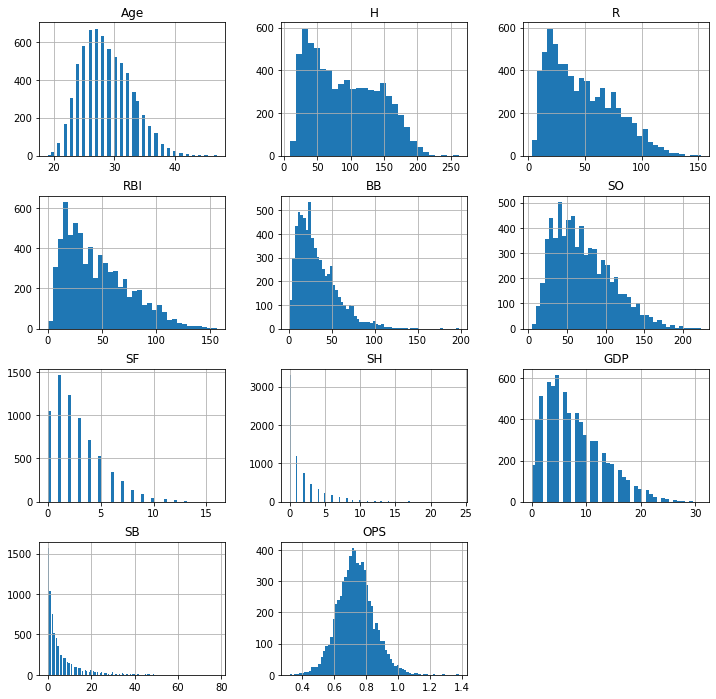

In [26]:
# check distribution of features
X_train.hist(figsize = [12,12], bins = 'auto')
plt.show()

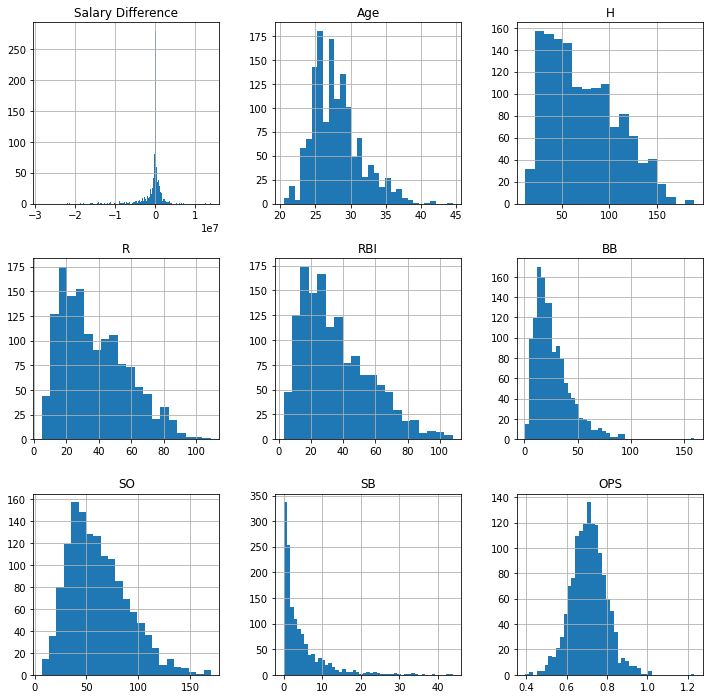

In [27]:
grouped_X_train.hist(figsize = [12,12], bins = 'auto')
plt.show()

## Preprocessing Pipeline (Removing Multicolinear Features)
Note: The new column transformer `bb_ct_2` performs a column transformation on the X features we want to keep after feature selection and includes categorical features. `bb_ct_3` performs only numeric transformations. 

In [28]:
# define categorical columns to be OHE
cat_cols = X_train.select_dtypes(['object']).columns

# define numeric columns to be standard scaled
num_cols = X_train.select_dtypes(['int', 'float']).columns
num_cols_grp = grouped_X_train.select_dtypes(['int', 'float']).columns

In [29]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler()), # apply a standard scaler
#                              ('poly', PolynomialFeatures(interaction_only = True # interactions 
#                                                          )) 
                             ])

# define a nominal transformation pipeline that OHE the cats, and MaxAbsScales the set
nominal_pipeline = Pipeline([('onehotenc', OneHotEncoder(categories="auto", # ohe the cat variables
                                                         sparse = False))]) 

In [30]:
# transform the selected columns with nominal, and numeric pipelines
bb_ct_2 = ColumnTransformer(transformers = 
                    [("nominalpipe", nominal_pipeline, cat_cols), 
                     ("numpipe", numeric_pipeline, num_cols)])

In [31]:
# transform the selected columns with numeric pipelines (for grouped set ONLY)
bb_ct_3 = ColumnTransformer(transformers = 
                    [("numpipe", numeric_pipeline, num_cols_grp)])

### Pickle the Transformers

In [32]:
# save the transformer
dump(bb_ct_2, open('pkl/bb_ct_2.pkl', 'wb'))

# save the grouped transformer
dump(bb_ct_3, open('pkl/bb_ct_3.pkl', 'wb'))

In [33]:
# load the transformer
bb_ct_2 = load(open('pkl/bb_ct_2.pkl', 'rb'))
bb_ct_3 = load(open('pkl/bb_ct_3.pkl', 'rb'))

**Transform `batting_basic`**

In [34]:
# inspect the preprocessed batting basic X train aka pp_bb_X_train
pp_bb_X_train = pd.DataFrame(bb_ct_2.fit_transform(X_train))
pp_bb_X_train.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.667892,-0.542499,-0.185007,-0.964840,-0.059588,-0.068526,-0.326470,3.970631,-0.698837,0.372018,-1.169237
1,0.806080,-1.102366,-0.924271,-0.998731,-0.495854,-0.708148,-1.166698,-0.643616,0.041642,-0.450319,-0.021475
2,-1.159216,-0.142595,-0.290616,-0.558145,-0.539480,0.464492,-0.746584,0.125425,-0.698837,-0.332842,-0.003818
3,-0.176568,0.957143,1.082303,1.746460,2.208994,1.983593,0.933873,-0.643616,-0.143478,-0.215366,1.320523
4,-0.913554,-1.342309,-1.170693,-1.235970,-1.150252,-0.708148,-1.166698,-0.643616,-1.254196,-0.215366,-1.098606


In [35]:
pp_bb_X_train.shape

(6855, 11)

Now lets do the same transformation for the `X_test`

In [36]:
# inspect the preprocessed batting basic X train aka pp_bb_X_test
pp_bb_X_test = pd.DataFrame(bb_ct_2.transform(X_test))
pp_bb_X_test.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.069094,0.717200,0.448648,0.831396,-0.190468,0.464492,1.353988,-0.643616,0.226762,-0.097889,0.693669
1,0.560418,-0.982395,-1.065084,-0.998731,-1.019373,-1.161213,-0.746584,-0.259096,-0.513717,-0.215366,0.225735
2,-1.896203,-0.722456,-0.466632,-0.930949,-0.539480,-1.054610,-1.166698,-0.259096,-1.069077,0.137065,0.676011
3,0.314756,-0.362542,-0.396226,-0.185341,-0.713987,0.011426,0.513759,0.894466,-0.698837,-0.685273,-0.268686
4,-0.667892,-0.562495,-0.642647,-0.897058,-1.062999,-0.201781,-0.746584,0.125425,-0.328598,0.254542,-1.010316


In [37]:
pp_bb_X_test.shape

(2286, 11)

**Transform `bb_grouped`**

In [38]:
# inspect the preprocessed grouped X train aka pp_grp_X_train
pp_grp_X_train = pd.DataFrame(bb_ct_3.fit_transform(grouped_X_train))
pp_grp_X_train.head()

,0,1,2,3,4,5,6,7,8
0,-0.616907,-0.877059,-1.143723,-0.997601,-0.862741,-1.030385,-1.139453,0.073167,-0.842799
1,0.470654,1.068806,1.397999,1.390432,2.046778,0.953878,1.758220,0.180635,1.616433
2,0.282236,-0.232622,1.461657,1.150683,0.608933,-0.338824,0.814924,0.741855,-0.395192
3,0.678011,-0.584133,2.106292,1.603872,1.930058,1.207334,1.497846,0.392314,0.716122
4,0.731881,-0.144744,0.158044,0.430726,0.718593,1.806190,1.043953,-0.578805,1.043381


In [39]:
# inspect the preprocessed grouped X train aka pp_grp_X_test
pp_grp_X_test = pd.DataFrame(bb_ct_3.transform(grouped_X_test))
pp_grp_X_test.head()

,0,1,2,3,4,5,6,7,8
0,0.249835,0.734034,-0.318009,-0.224682,-0.015655,-0.362266,0.092604,-0.511936,0.501921
1,-0.305196,-0.877059,-0.996109,-1.411369,-0.783277,-1.382027,-1.855901,-0.762694,-0.516023
2,0.263331,-0.095923,-0.341074,-0.186616,-0.385957,-0.678744,0.029180,-0.066143,0.175526
3,0.124363,-0.877059,-1.300562,-0.716239,-1.260061,-1.147599,-0.552200,-0.094005,-2.841450
4,0.229243,-0.193565,-0.258041,0.094747,-0.910420,0.571537,-0.587435,0.964752,-0.740206


**Log Transforming Salary**

In [40]:
# basic y
log_y_train = np.log(y_train)
log_y_test = np.log(y_test)

# grouped y
log_grp_y_train = np.log(grouped_y_train)
log_grp_y_test = np.log(grouped_y_test)

## Feature Selection

**Multicollinearity**

In [41]:
corr_df = pp_bb_X_train.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))

# set index to pairs
corr_df.set_index(['pairs'], inplace = True)

#drop level columns
corr_df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
corr_df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
corr_df.drop_duplicates(inplace=True)

In [42]:
corr_df[(corr_df.cc>.5) & (corr_df.cc <1)]

,cc
pairs,
"(1, 2)",0.938189
"(2, 3)",0.878783
"(1, 3)",0.870885
"(4, 2)",0.815621
"(4, 3)",0.769911
"(1, 4)",0.726634
"(5, 3)",0.720506
"(2, 5)",0.715829
"(8, 1)",0.704948


## Modeling

In [43]:
# import my helper function to get model results
from functions import *

### Linear Regression

**Batting Basic Model**

In [44]:
# build pipeline 
steps = [('preprocess', bb_ct_2), 
         ('model', LinearRegression())]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, log_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(sparse=False))]),
                                                  Index([], dtype='object')),
                                                 ('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'H', 'R', 'RBI', 'BB', 'SO', 'SF', 'SH', 'GDP', 'SB', 'OPS'], dtype='object'))])),
                ('model', LinearRegression())])

In [45]:
# instantiate the model
lr_model = Pipeline(steps).steps[1][1]  # gets the class name of the model

# get model results
model_results(lr_model, pp_bb_X_train, log_y_train, pp_bb_X_test, log_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.4817
LinearRegression() Test R2:                   0.465
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.4797
LinearRegression() Cross Validation RMSE:    4648766
-------------------------------------------------------
LinearRegression() Training RMSE:            5027971
LinearRegression() Test RMSE:                4925622


**Batting Grouped Model**

In [46]:
# build pipeline 
steps = [('preprocess', bb_ct_3), 
         ('model', LinearRegression())]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(grouped_X_train, log_grp_y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Salary Difference', 'Age', 'H', 'R', 'RBI', 'BB', 'SO', 'SB', 'OPS'], dtype='object'))])),
                ('model', LinearRegression())])

In [47]:
# instantiate the model
lr_model = Pipeline(steps).steps[1][1]  # gets the class name of the model

# get model results
model_results(lr_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.6249
LinearRegression() Test R2:                   0.6533
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.6141
LinearRegression() Cross Validation RMSE:    2340267
-------------------------------------------------------
LinearRegression() Training RMSE:            2328262
LinearRegression() Test RMSE:                1945628


Moving forward, we will be modeling with the `batting_grouped` data. The RMSE is much more reasonable with an R2 that best explains the salary once the batting salaries are grouped by individual player averages. 

## PCA

In [48]:
from sklearn.decomposition import PCA

In [49]:
pca = PCA(n_components= 0.90) # Check out how `n_components` works

X_train_pca2 = pca.fit_transform(pp_grp_X_train)
X_test_pca2 = pca.transform(pp_grp_X_test)

In [50]:
lr_pca = LinearRegression()

# get model results
model_results(lr_pca, X_train_pca2, log_grp_y_train, X_test_pca2, log_grp_y_test)

             LinearRegression() RESULTS
LinearRegression() Training R2:               0.6035
LinearRegression() Test R2:                   0.6405
-------------------------------------------------------
LinearRegression() Cross Validation R2:       0.5949
LinearRegression() Cross Validation RMSE:    2460514
-------------------------------------------------------
LinearRegression() Training RMSE:            2410300
LinearRegression() Test RMSE:                2116347


In [51]:
lr_pca.coef_

array([ 0.37334503, -0.1187593 ,  0.21171953, -0.0350867 , -0.14718081])

### Support Vector Machine

In [52]:
from sklearn import svm
from sklearn.svm import LinearSVR

In [53]:
# build pipeline 
svm_steps = [('preprocess', bb_ct_3),
            ('model', svm.SVR())]

svm_pipeline = Pipeline(svm_steps)

# define parameters in the grid
svm_grid = {
            'model__kernel': ['rbf'],
            'model__C': [0.1, 1],
            'model__degree': [2,3]
           }  

# get best R2 score from grid search
svm_model = GridSearchCV(estimator = svm_pipeline,
                         param_grid = svm_grid,
                         scoring = 'r2')


# fit and give me the best params
svm_model.fit(grouped_X_train, log_grp_y_train)
display(svm_model.best_params_)
print("Best CV Score:", round(svm_model.best_score_,5))

{'model__C': 1, 'model__degree': 2, 'model__kernel': 'rbf'}

Best CV Score: 0.70085


In [54]:
# instantiate the model
best_model = svm_model.best_estimator_
svm_model = best_model.steps[1][1]  # gets the class name of the model

# get model results
model_results(svm_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             SVR(C=1, degree=2) RESULTS
SVR(C=1, degree=2) Training R2:               0.7588
SVR(C=1, degree=2) Test R2:                   0.7266
-------------------------------------------------------
SVR(C=1, degree=2) Cross Validation R2:       0.7012
SVR(C=1, degree=2) Cross Validation RMSE:    3903155
-------------------------------------------------------
SVR(C=1, degree=2) Training RMSE:            1759072
SVR(C=1, degree=2) Test RMSE:                1755210


### Gradient Boosting Regressor

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

In [83]:
# build pipeline 
ensemble_steps = [('preprocess', bb_ct_3), 
                  ('model', GradientBoostingRegressor(random_state = 42))]

ensemble_pipeline = Pipeline(ensemble_steps)

# define parameters in the grid
ensemble_grid = {
                'model__learning_rate': [0.1], ## BEST PARAMETERS
                'model__n_estimators': [130],
                'model__max_depth': [2],
                'model__max_features': [7]
               }  

# get best R2 score from grid search
ensemble_model = GridSearchCV(estimator = ensemble_pipeline,
                         param_grid = ensemble_grid,
                         scoring = 'r2')

# fit and give me the best params
ensemble_model.fit(grouped_X_train, log_grp_y_train)
display(ensemble_model.best_params_)
print("Best CV Score:", round(ensemble_model.best_score_,5))

{'model__learning_rate': 0.1,
 'model__max_depth': 2,
 'model__max_features': 7,
 'model__n_estimators': 130}

Best CV Score: 0.74197


In [84]:
# instantiate the model
best_model = ensemble_model.best_estimator_
ensemble_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(ensemble_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             GradientBoostingRegressor(max_depth=2, max_features=7, n_estimators=130,
                          random_state=42) RESULTS
GradientBoostingRegressor(max_depth=2, max_features=7, n_estimators=130,
                          random_state=42) Training R2:               0.8194
GradientBoostingRegressor(max_depth=2, max_features=7, n_estimators=130,
                          random_state=42) Test R2:                   0.7502
-------------------------------------------------------
GradientBoostingRegressor(max_depth=2, max_features=7, n_estimators=130,
                          random_state=42) Cross Validation R2:       0.7421
GradientBoostingRegressor(max_depth=2, max_features=7, n_estimators=130,
                          random_state=42) Cross Validation RMSE:    1947113
-------------------------------------------------------
GradientBoostingRegressor(max_depth=2, max_features=7, n_estimators=130,
                          random_state=42) Training RMSE:            1625401
G

In [107]:
ensemble_model

GradientBoostingRegressor(max_depth=2, max_features=7, n_estimators=130,
                          random_state=42)

### Predicting A Salary Using The Gradient Boost Model

In [123]:
# create an empty df with news column for input of values to determine sale price
input_df = pd.DataFrame(columns = grouped_X_train.columns)

In [124]:
input_df.columns

Index(['Salary Difference', 'Age', 'H', 'R', 'RBI', 'BB', 'SO', 'SB', 'OPS'], dtype='object')

In [112]:
# enter values for input_df
salary_diff_input = (input("Enter Salary Difference: "))
age_input = (input("Enter Age: "))
H_input = (input("Enter H: "))
R_input = (input("Enter R: "))
RBI_input = (input("Enter RBI: "))
BB_input = (input("Enter BB: "))
SO_input = (input("Enter SO: "))
SB_input = (input("Enter SB: "))
OPS_input = (input("Enter OPS: "))

# assign input values to input_df columns
input_df.loc[0, 'Salary Difference'] = salary_diff_input
input_df.loc[0, 'Age' ] = age_input
input_df.loc[0, 'H'] = H_input
input_df.loc[0, 'R' ] = R_input
input_df.loc[0, 'RBI' ] = RBI_input
input_df.loc[0, 'BB'] = BB_input
input_df.loc[0, 'SO' ] = SO_input
input_df.loc[0, 'SB'] = SB_input
input_df.loc[0, 'OPS'] = OPS_input

Enter Salary Difference: 5000000
Enter Age: 35
Enter H: 120
Enter R: 80
Enter RBI: 100
Enter BB: 40
Enter SO: 50
Enter SB: 20
Enter OPS: 0.950


In [113]:
input_df

,Salary Difference,Age,H,R,RBI,BB,SO,SB,OPS
0,5000000,35,120,80,100,40,50,20,0.950


In [120]:
# fit the model
ensemble_model.fit(grouped_X_train, log_grp_y_train)

GradientBoostingRegressor(max_depth=2, max_features=7, n_estimators=130,
                          random_state=42)

In [122]:
# pickling the model 
import joblib

joblib.dump(ensemble_model, "pkl/bb_model.pkl")

['pkl/bb_model.pkl']

In [121]:
# Make predictions on the input_df
y_pred = ensemble_model.predict(input_df)

In [118]:
round(np.exp(y_pred)[0], 0)

15850423.0

In [119]:
# saving best model to disk
dump(ensemble_model, open('pkl/batting_basic_model.pkl', 'wb'))

**Note: The above steps are applied to a user-friendly version application using StreamLit.**

### Random Forest

In [60]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
# build pipeline 
rfr_steps = [('preprocess', bb_ct_3), 
            ('model', RandomForestRegressor(random_state = 42))]

rfr_pipeline = Pipeline(rfr_steps)

# define parameters in the grid
rfr_grid = {'model__n_estimators': [110, 120, 130],
            'model__max_depth': [3, 4],
#             'model__min_samples_split': [2],
#             'model__min_samples_leaf': [2],
            'model__max_features': [8]}  

# get best R2 score from grid search
rfr_model = GridSearchCV(estimator = rfr_pipeline,
                           param_grid = rfr_grid,
                           scoring = 'r2')

# fit and give me the best params
rfr_model.fit(grouped_X_train, log_grp_y_train)
rfr_model.best_params_
display(rfr_model.best_params_)
print("Best CV Score:", round(rfr_model.best_score_,5))

{'model__max_depth': 4, 'model__max_features': 8, 'model__n_estimators': 130}

Best CV Score: 0.73603


In [63]:
# instantiate the model
best_model = rfr_model.best_estimator_
rfr_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(rfr_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             RandomForestRegressor(max_depth=4, max_features=8, n_estimators=130,
                      random_state=42) RESULTS
RandomForestRegressor(max_depth=4, max_features=8, n_estimators=130,
                      random_state=42) Training R2:               0.7834
RandomForestRegressor(max_depth=4, max_features=8, n_estimators=130,
                      random_state=42) Test R2:                   0.7064
-------------------------------------------------------
RandomForestRegressor(max_depth=4, max_features=8, n_estimators=130,
                      random_state=42) Cross Validation R2:       0.736
RandomForestRegressor(max_depth=4, max_features=8, n_estimators=130,
                      random_state=42) Cross Validation RMSE:    1975494
-------------------------------------------------------
RandomForestRegressor(max_depth=4, max_features=8, n_estimators=130,
                      random_state=42) Training RMSE:            1878130
RandomForestRegressor(max_depth=4, max_features=8,

### CatBoost

In [64]:
from catboost import CatBoostRegressor

In [65]:
# build pipeline 
cbr_steps = [('preprocess', bb_ct_3), 
            ('model', CatBoostRegressor(random_state = 42, 
                                        allow_writing_files=False,
                                        verbose = False))]

cbr_pipeline = Pipeline(cbr_steps)

# define parameters in the grid
cbr_grid = {
                'model__learning_rate': [0.1],
                'model__iterations': [250],
                'model__max_depth': [4],
#                 'model__l2_leaf_reg': [0.1, 1, 10]
               }  

# get best R2 score from grid search
cbr_model = GridSearchCV(estimator = cbr_pipeline,
                         param_grid = cbr_grid,
                         scoring = 'r2')

# fit and give me the best params
cbr_model.fit(grouped_X_train, log_grp_y_train)
cbr_model.best_params_
display(cbr_model.best_params_)
print("Best CV Score:", round(cbr_model.best_score_,5))

{'model__iterations': 250, 'model__learning_rate': 0.1, 'model__max_depth': 4}

Best CV Score: 0.74164


In [66]:
# instantiate the model
best_model = cbr_model.best_estimator_
cbr_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(cbr_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             <catboost.core.CatBoostRegressor object at 0x16cf7b100> RESULTS
<catboost.core.CatBoostRegressor object at 0x16cf7b100> Training R2:               0.8631
<catboost.core.CatBoostRegressor object at 0x16cf7b100> Test R2:                   0.7629
-------------------------------------------------------
<catboost.core.CatBoostRegressor object at 0x16cf7b100> Cross Validation R2:       0.7416
<catboost.core.CatBoostRegressor object at 0x16cf7b100> Cross Validation RMSE:    1902485
-------------------------------------------------------
<catboost.core.CatBoostRegressor object at 0x16cf7b100> Training RMSE:            1446148
<catboost.core.CatBoostRegressor object at 0x16cf7b100> Test RMSE:                1737983


### XGBoost

In [67]:
import xgboost as xgb
from xgboost import XGBRegressor

In [68]:
# build pipeline 
xgb_steps = [('preprocess', bb_ct_3), 
            ('model', XGBRegressor())]

xgb_pipeline = Pipeline(xgb_steps)

# define parameters in the grid
xgb_grid = {'model__n_estimators': [100, 120, 130],
            'model__max_depth': [4, 5,6],
            'model__learning_rate': [0.1]}  

# get best R2 score from grid search
xgb_model = GridSearchCV(estimator = xgb_pipeline,
                           param_grid = xgb_grid,
                           scoring = 'r2')

# fit and give me the best params
xgb_model.fit(grouped_X_train, log_grp_y_train)
display(xgb_model.best_params_)
print("Best CV Score:", round(xgb_model.best_score_,5))

{'model__learning_rate': 0.1,
 'model__max_depth': 4,
 'model__n_estimators': 100}

Best CV Score: 0.74507


In [69]:
# instantiate the model
best_model = xgb_model.best_estimator_
xgb_model = best_model.steps[1][1]   # gets the class name of the model

# get model results
model_results(xgb_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...) RESULTS
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             impor

### MLP Regressor (Neural Network)

In [70]:
from sklearn.neural_network import MLPRegressor

In [71]:
# build pipeline 
mlp_steps = [('preprocess', bb_ct_3), 
             ('model', MLPRegressor(random_state = 42, verbose = False))]

mlp_pipeline = Pipeline(mlp_steps)

# define parameters in the grid
mlp_grid = {'model__hidden_layer_sizes': [(1000,)],
            'model__activation': ['relu'],
            'model__solver': ['adam'],
            'model__max_iter': [1000]
           }

# get best R2 score from grid search
mlp_model = GridSearchCV(estimator = mlp_pipeline,
                           param_grid = mlp_grid,
                           scoring = 'r2')

# fit and give me the best params
mlp_model.fit(grouped_X_train, log_grp_y_train)
display(mlp_model.best_params_)
print("Best CV Score:", round(mlp_model.best_score_,5))

{'model__activation': 'relu',
 'model__hidden_layer_sizes': (1000,),
 'model__max_iter': 1000,
 'model__solver': 'adam'}

Best CV Score: 0.67839


In [72]:
# instantiate the model
best_model = mlp_model.best_estimator_
mlp_model = best_model.steps[1][1]   # gets the class name of the model

model_results(mlp_model, pp_grp_X_train, log_grp_y_train, pp_grp_X_test, log_grp_y_test)

             MLPRegressor(hidden_layer_sizes=(1000,), max_iter=1000, random_state=42) RESULTS
MLPRegressor(hidden_layer_sizes=(1000,), max_iter=1000, random_state=42) Training R2:               0.7705
MLPRegressor(hidden_layer_sizes=(1000,), max_iter=1000, random_state=42) Test R2:                   0.7128
-------------------------------------------------------


/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization

MLPRegressor(hidden_layer_sizes=(1000,), max_iter=1000, random_state=42) Cross Validation R2:       0.6791
MLPRegressor(hidden_layer_sizes=(1000,), max_iter=1000, random_state=42) Cross Validation RMSE:    4241884
-------------------------------------------------------
MLPRegressor(hidden_layer_sizes=(1000,), max_iter=1000, random_state=42) Training RMSE:            2351483
MLPRegressor(hidden_layer_sizes=(1000,), max_iter=1000, random_state=42) Test RMSE:                2025362


/Users/eric/miniforge3/envs/tf_miniforge/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


# Visualize the Model Fit on Test Set

### Predicted Plots & Residuals

In [86]:
# get residuals
y_pred_test = ensemble_model.predict(pp_grp_X_test)
resid = np.exp(log_grp_y_test) - np.exp(y_pred_test)

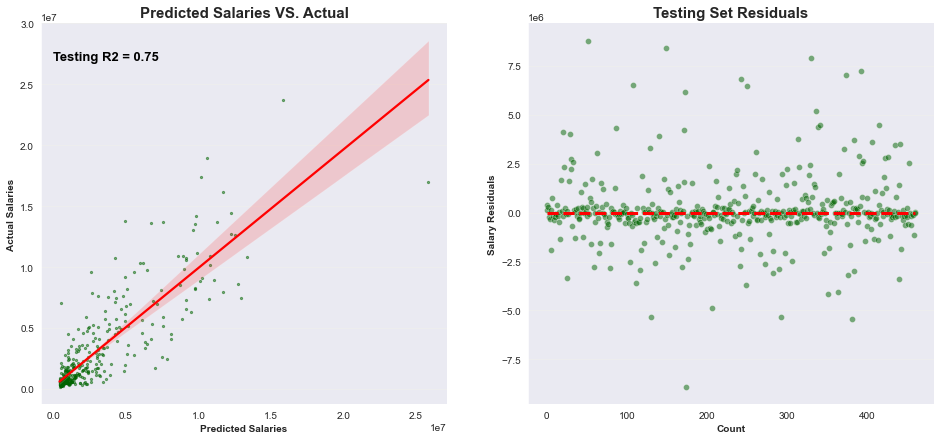

In [90]:
sns.set_style("dark")

# plots TESTING set & residuals
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# plots regplots
sns.regplot(ax = axes[0], 
            x = np.exp(y_pred_test), 
            y = np.exp(log_grp_y_test),
            scatter_kws={'s':5, 'alpha': 0.5, 'color': 'darkgreen'},
            line_kws={"color": "red"})

# annotate regplot
axes[0].text(1e2, 2.7e7, "Testing R2 = 0.75", 
             horizontalalignment='left', fontsize=13, color='black', weight = 'bold')

# regplot labels
axes[0].set_xlabel('Predicted Salaries', weight = 'bold') 
axes[0].set_ylabel('Actual Salaries', weight = 'bold') 
axes[0].set_title('Predicted Salaries VS. Actual', weight = 'bold', fontdict = {'fontsize' : 15})

# plots residual
sns.scatterplot(ax = axes[1], 
                x = range(log_grp_y_test.shape[0]),
                y = resid, 
                alpha=0.5,
                color= "darkgreen")
# plot zero line in residual
sns.lineplot(ax = axes[1], 
             x=range(log_grp_y_test.shape[0]), y = 0, 
             color='red', linestyle="dashed", linewidth = 3)

# residual labels
axes[1].set_xlabel('Count', weight = 'bold') 
axes[1].set_ylabel('Salary Residuals', weight = 'bold') 
axes[1].set_title('Testing Set Residuals', weight = 'bold', fontdict = {'fontsize' : 15})

# removes top and right side axis
sns.despine(right = True)

# set gridline visibility
axes[0].set_axisbelow(True)
axes[0].yaxis.grid(True, color='#EEEEEE')
axes[0].xaxis.grid(False)
axes[1].set_axisbelow(True)
axes[1].yaxis.grid(True, color='#EEEEEE')
axes[1].xaxis.grid(False)

plt.show()
fig.savefig('plots/batting_basic_resids.png');

### Assessing the Important Features

Lets now assess which features in the Gradient Boost model are the most important when making a prediction. 

In [91]:
top_features

['Salary Difference', 'Age', 'H', 'R', 'RBI', 'BB', 'SO', 'SB', 'OPS']

In [92]:
# get feature weights
best_model_coef = ensemble_model.feature_importances_
best_model_coef

array([0.2799431 , 0.08747058, 0.38833181, 0.15876655, 0.0294305 ,
       0.04135574, 0.00490848, 0.0025895 , 0.00720373])

In [93]:
# check feature importances 
feat_imp_series = pd.Series(best_model_coef, 
                            index = pp_grp_X_train.columns)

# preview first 5
feat_imp_series[:5]

0    0.279943
1    0.087471
2    0.388332
3    0.158767
4    0.029430
dtype: float64

We need to index these importance features values with their appropriate values to make sense of which Importance value is associated with which Feature. We'll merge the `top_features_df` with the `feat_imp_df`. 

In [94]:
top_features_list = top_features
top_features_df = pd.DataFrame(top_features_list)
top_features_df.head()

,0
0,Salary Difference
1,Age
2,H
3,R
4,RBI


In [95]:
# convert feat_imp_series into a df
feat_imp_df = pd.DataFrame(feat_imp_series)
feat_imp_df.head()

,0
0,0.279943
1,0.087471
2,0.388332
3,0.158767
4,0.029430


In [96]:
# merge the feature names and feature importance dataframes based on index
merged = pd.merge(top_features_df, feat_imp_df, left_index=True, right_index=True)

# rename the new merged dataframe
merged = merged.rename(columns = {'0_x': 'Feature', '0_y': 'Importance'})
merged.head()

,Feature,Importance
0,Salary Difference,0.279943
1,Age,0.087471
2,H,0.388332
3,R,0.158767
4,RBI,0.029430


In [97]:
# sort by top 15 most important features
sorted_features = merged.sort_values('Importance', ascending = False)

# create a top 15 features df
top_15_features = sorted_features.head(15)
top_15_features

,Feature,Importance
2,H,0.388332
0,Salary Difference,0.279943
3,R,0.158767
1,Age,0.087471
5,BB,0.041356
4,RBI,0.029430
8,OPS,0.007204
6,SO,0.004908
7,SB,0.002590


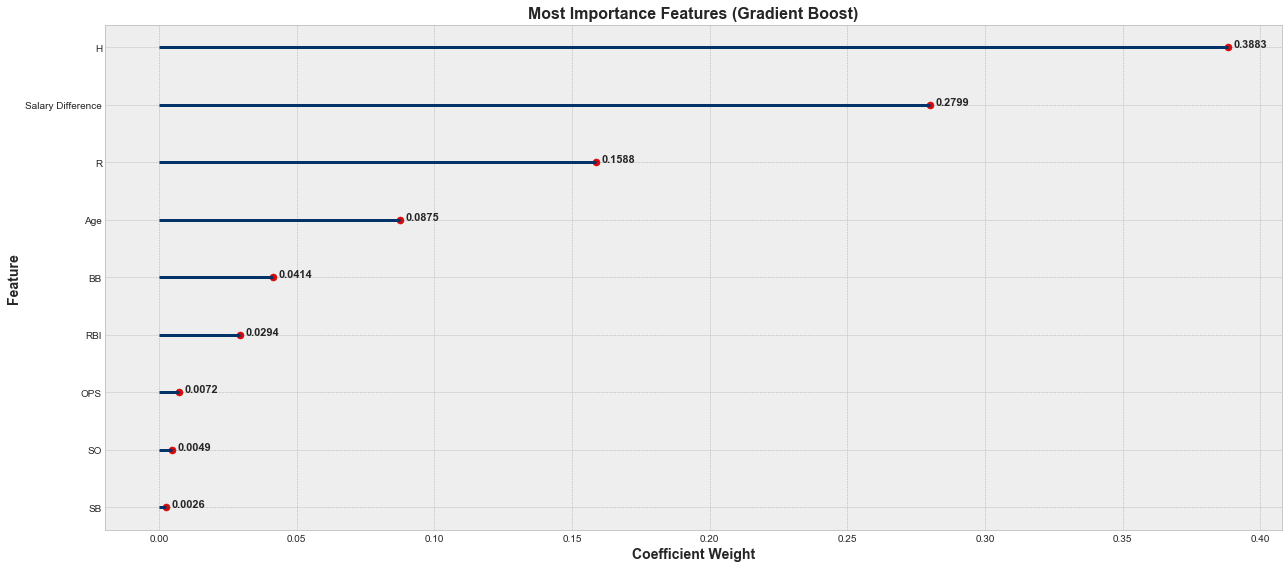

In [99]:
# plot a lollipop plot of top 15 most important features
fig, ax = plt.subplots(figsize=(18, 8))
plt.style.use('bmh')

# sort by descending
top_15_features= top_15_features.sort_values(by = 'Importance')

# plots the lines
plt.hlines(y = top_15_features['Feature'],  # feature
           xmin = 0,
           xmax = top_15_features['Importance'],  # importance
           color = '#013369', linewidth = 3)

plt.scatter(top_15_features['Importance'], # Count values
            top_15_features['Feature'],  # positions
            color='#d50a0a', 
            alpha=1, s = 50)

# annotate the scatter plot values
for idx, row in top_15_features.iterrows():
    ax.annotate(round(row['Importance'],4), (row['Importance'], row['Feature'] ), 
                weight = "bold", fontsize = 11, 
                xytext=(row['Importance'] + 0.002, row['Feature'])) # offset annotate

plt.title('Most Importance Features (Gradient Boost)', weight = "bold", fontsize = 16)
plt.ylabel('Feature', weight = "bold", fontsize = 14)
plt.xlabel('Coefficient Weight', weight = "bold", fontsize = 14)

plt.tight_layout()
plt.show()
#fig.savefig('images/bb_important_features.png');